In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization (Optional for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

# Clustering
import hdbscan
import umap

# Evaluation
from sklearn.metrics import silhouette_score
from hdbscan.validity import validity_index

# Misc
import joblib
import os


c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your dataset
df = pd.read_excel('sample_customer_database_5000_singapore.xlsx')

# Basic info
print("✅ Dataset Loaded")
print(df.shape)
print(df.info())


✅ Dataset Loaded
(5000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Customer ID    5000 non-null   object        
 1   Full Name      5000 non-null   object        
 2   Email Address  5000 non-null   object        
 3   Phone Number   5000 non-null   int64         
 4   Date Joined    5000 non-null   datetime64[ns]
 5   Location       5000 non-null   object        
 6   Gender         5000 non-null   object        
 7   Loyalty Tier   5000 non-null   object        
 8   Notes          5000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 351.7+ KB
None


EDA: Exploratory Data Analysis

In [3]:
#1. First look at the data
print(df.head())  # First 5 rows

  Customer ID        Full Name                Email Address  Phone Number  \
0       C0001     Norma Fisher          ysullivan@yahoo.com      82421948   
1       C0002      Levi Durham            qgrimes@gmail.com      97535139   
2       C0003   Kimberly Olsen  sean96@johnston-roberts.com      71122018   
3       C0004   Matthew Davies    nguyendarrell@hotmail.com      41352560   
4       C0005  Angela Martinez    myersmitchell@johnson.com        869141   

  Date Joined     Location  Gender Loyalty Tier  \
0  2023-08-11     Tampines  Female     Platinum   
1  2022-11-24      Geylang  Female     Platinum   
2  2023-06-19     Tampines  Female     Platinum   
3  2025-04-04   Ang Mo Kio    Male       Silver   
4  2025-01-15  Bukit Batok  Female     Platinum   

                                               Notes  
0                        Together range line beyond.  
1  Language ball floor meet usually board necessary.  
2                 Support time operation wear often.  
3         

In [4]:
# 2. Dataset Shape & Info
print("✅ Dataset Shape:", df.shape)
print("\n🧠 Data Types:\n", df.dtypes)
print("\n🔍 Missing Values:\n", df.isnull().sum())
print("\n🔢 Unique Values per Column:")
for col in df.columns:
    print(f" - {col}: {df[col].nunique()} unique values")

✅ Dataset Shape: (5000, 9)

🧠 Data Types:
 Customer ID              object
Full Name                object
Email Address            object
Phone Number              int64
Date Joined      datetime64[ns]
Location                 object
Gender                   object
Loyalty Tier             object
Notes                    object
dtype: object

🔍 Missing Values:
 Customer ID      0
Full Name        0
Email Address    0
Phone Number     0
Date Joined      0
Location         0
Gender           0
Loyalty Tier     0
Notes            0
dtype: int64

🔢 Unique Values per Column:
 - Customer ID: 5000 unique values
 - Full Name: 4835 unique values
 - Email Address: 4983 unique values
 - Phone Number: 4998 unique values
 - Date Joined: 1084 unique values
 - Location: 27 unique values
 - Gender: 2 unique values
 - Loyalty Tier: 3 unique values
 - Notes: 5000 unique values


<Figure size 1200x500 with 0 Axes>

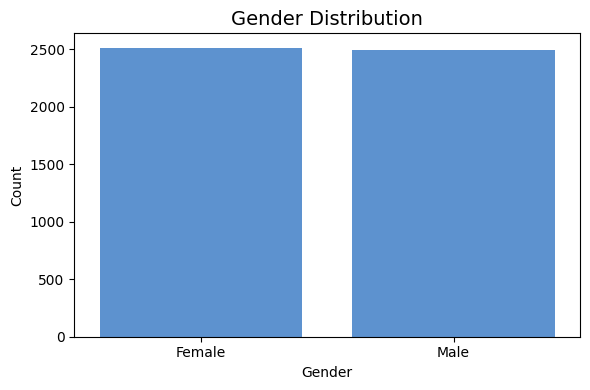

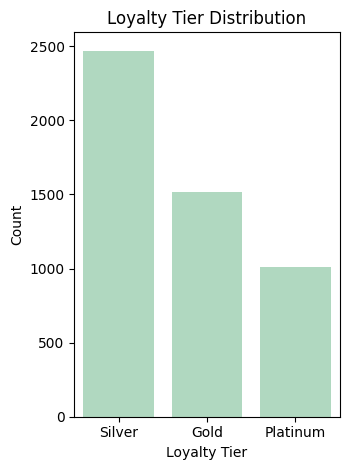

In [5]:
# 3. Categorical Distributions
plt.figure(figsize=(12, 5))

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender', order=df['Gender'].value_counts().index, color='#4A90E2')
plt.title("Gender Distribution", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Loyalty Tier', order=['Silver', 'Gold', 'Platinum'],color='#A9DFBF')
plt.title("Loyalty Tier Distribution")
plt.xlabel("Loyalty Tier")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

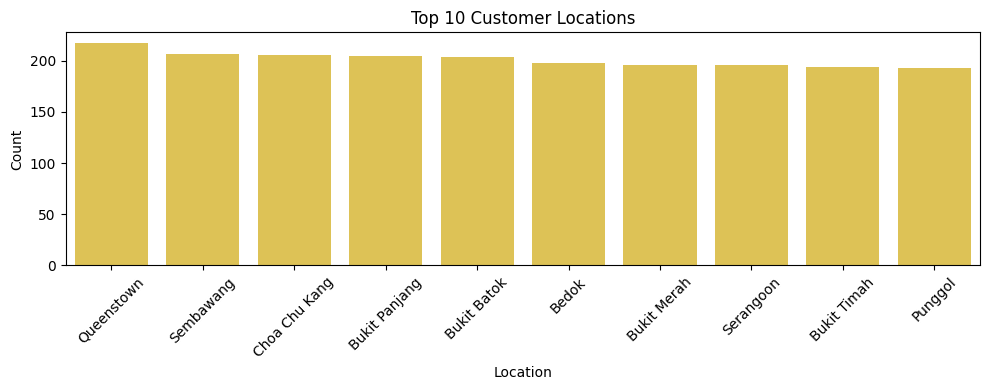

In [6]:
# 4. Location Distribution (Top 10)
if 'Location' in df.columns:
    top_locations = df['Location'].value_counts().nlargest(10)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_locations.index, y=top_locations.values, color='#F4D03F')
    plt.title("Top 10 Customer Locations")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

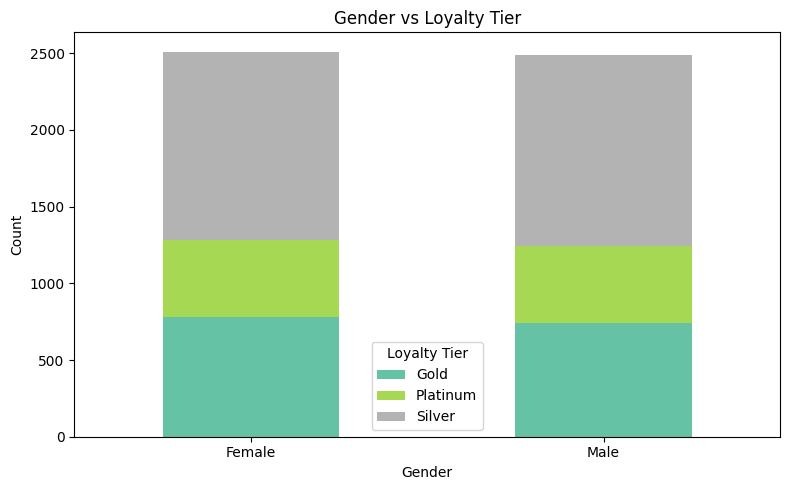

In [7]:
#5 gender vs loyalty tier 
pd.crosstab(df['Gender'], df['Loyalty Tier']).plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')
plt.title('Gender vs Loyalty Tier')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Feature Engineering Section

In [8]:
# Ensure 'Date_Joined' is in datetime format
df['Date Joined'] = pd.to_datetime(df['Date Joined'], errors='coerce') 

# Feature Engineering from Date_Joined
df['Join_Year'] = df['Date Joined'].dt.year
df['Join_Month'] = df['Date Joined'].dt.month
df['Join_Quarter'] = df['Date Joined'].dt.quarter

# Display engineered features
df[['Date Joined', 'Join_Year', 'Join_Month', 'Join_Quarter']].head()


,Date Joined,Join_Year,Join_Month,Join_Quarter
0,2023-08-11,2023,8,3
1,2022-11-24,2022,11,4
2,2023-06-19,2023,6,2
3,2025-04-04,2025,4,2
4,2025-01-15,2025,1,1


In [9]:
# 2. 🏅 Ordinal Encoding: Loyalty Tier
df['Loyalty_Tier_Score'] = df['Loyalty Tier'].map({'Silver': 1, 'Gold': 2, 'Platinum': 3})
print(df[['Loyalty Tier', 'Loyalty_Tier_Score']].drop_duplicates().sort_values(by='Loyalty_Tier_Score'))


   Loyalty Tier  Loyalty_Tier_Score
3        Silver                   1
24         Gold                   2
0      Platinum                   3


Pre processing

In [10]:
# 1. 🧠 Define feature groups
categorical_cols = ['Location', 'Gender', 'Join_Year', 'Join_Month', 'Join_Quarter']
numerical_cols = ['Loyalty_Tier_Score']  # Keep this scalable

In [11]:
# 2. 🔢 One-Hot Encode Categorical Columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(df[categorical_cols])

In [12]:
# 3. 📏 Scale Numerical Columns
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

In [13]:
# 4. 🔗 Combine Encoded + Scaled Features
combined_features = np.hstack([cat_encoded, num_scaled])
print("✅ Combined Feature Shape:", combined_features.shape)

✅ Combined Feature Shape: (5000, 50)


In [14]:
#Step 1 : Dimensionality Reduction with UMAP
#  UMAP to reduce dimensions (for clustering)
print("📦 Training data shape before UMAP:", combined_features.shape)

umap_model = umap.UMAP(
    n_neighbors=120,
    min_dist=0.1,
    n_components=10,
    random_state=42
)
umap_model.fit(combined_features)  # Fit first

# Step 2: Transform the data
embed = umap_model.transform(combined_features)

print("✅ UMAP Embedding Shape:", embed.shape)


📦 Training data shape before UMAP: (5000, 50)


c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP Embedding Shape: (5000, 10)


c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
#step 2: Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=400,   
    min_samples=5,
    prediction_data=True
)
df['HDBSCAN_Cluster_Label'] = clusterer.fit_predict(embed)

# 🏷️ View sample cluster assignments
print(df[['HDBSCAN_Cluster_Label', 'Gender', 'Location', 'Loyalty Tier']].head())


   HDBSCAN_Cluster_Label  Gender     Location Loyalty Tier
0                      3  Female     Tampines     Platinum
1                      1  Female      Geylang     Platinum
2                      2  Female     Tampines     Platinum
3                      2    Male   Ang Mo Kio       Silver
4                      0  Female  Bukit Batok     Platinum


c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
# 🔍 Step 3: Evaluate Silhouette Score (excluding noise)
mask = df['HDBSCAN_Cluster_Label'] != -1
if mask.sum() > 1:
    silhouette = silhouette_score(embed[mask], df.loc[mask, 'HDBSCAN_Cluster_Label'])
    print("✅ Silhouette Score:", round(silhouette, 3))
else:
    print("⚠️ Too much noise — Silhouette not computed")
    

✅ Silhouette Score: 0.953


In [17]:
# 🧪 Step 4: DBCV Score
labels = df.loc[mask, 'HDBSCAN_Cluster_Label'].values
X = embed[mask].astype(np.float64)
dbcv_score = validity_index(X, labels, metric='euclidean')
print("📈 DBCV Score:", round(dbcv_score, 3))

📈 DBCV Score: 0.972


In [18]:
# 🧮 Step 5: Count of Clusters
n_clusters = len(np.unique(df['HDBSCAN_Cluster_Label'])) - (1 if -1 in df['HDBSCAN_Cluster_Label'] else 0)
print("📊 Number of clusters (excluding noise):", n_clusters)

📊 Number of clusters (excluding noise): 4


Cluster Visualisation

c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25548\399239124.py:26: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Lenovo\Downloads\Year 3 Major project\ML models\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


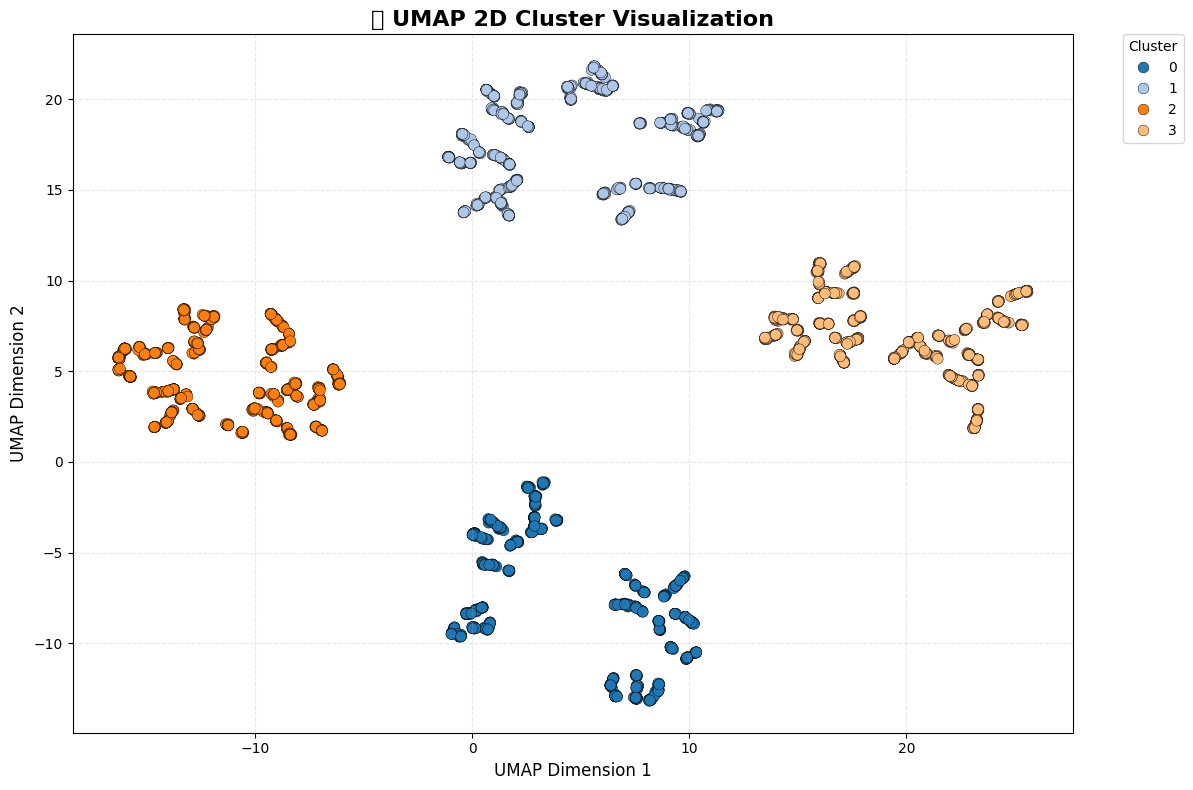

In [19]:
# Step 1 : 2D UMAP Projection
umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(combined_features)
df['UMAP1'] = umap_2d[:, 0]
df['UMAP2'] = umap_2d[:, 1]

# Step 2: Plot Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df[df['HDBSCAN_Cluster_Label'] != -1],
    x='UMAP1',
    y='UMAP2',
    hue='HDBSCAN_Cluster_Label',
    palette='tab20',
    legend='full',
    s=60,
    edgecolor='black',
    linewidth=0.3
)

# Styling
plt.title("📌 UMAP 2D Cluster Visualization", fontsize=16, weight='bold')
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


Cluster Profile Labels

In [20]:
# Step 1: Filter out noise (DO NOT overwrite original df)
df_cleaned_clusters = df[df['HDBSCAN_Cluster_Label'] != -1].copy()

# Step 2: Group and aggregate cluster profiles
cluster_profiles_summary = df_cleaned_clusters.groupby('HDBSCAN_Cluster_Label').agg({
    'Gender': lambda x: x.value_counts(normalize=True).to_dict(),
    'Loyalty_Tier_Score': lambda x: x.value_counts(normalize=True).to_dict(),
    'Location': lambda x: x.value_counts().head(5).to_dict(),
    'Join_Year': lambda x: x.value_counts(normalize=True).to_dict(),
    'Join_Month': lambda x: x.value_counts(normalize=True).to_dict(),
    'Join_Quarter': lambda x: x.value_counts(normalize=True).to_dict(),
})

# Step 3: Display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Step 4: View result
cluster_profiles_summary


,Gender,Loyalty_Tier_Score,Location,Join_Year,Join_Month,Join_Quarter
HDBSCAN_Cluster_Label,,,,,,
0,"{'Female': 0.5062794348508635, 'Male': 0.4937205651491366}","{1: 0.4976452119309262, 2: 0.304552590266876, 3: 0.1978021978021978}","{'Bedok': 60, 'Punggol': 58, 'Bukit Batok': 56, 'Bishan': 52, 'Serangoon': 51}","{2024: 0.3492935635792779, 2023: 0.3359497645211931, 2025: 0.31475667189952905}","{3: 0.35714285714285715, 1: 0.3328100470957614, 2: 0.31004709576138145}",{1: 1.0}
1,"{'Male': 0.532051282051282, 'Female': 0.46794871794871795}","{1: 0.5096153846153846, 2: 0.2932692307692308, 3: 0.1971153846153846}","{'Choa Chu Kang': 61, 'Queenstown': 60, 'Bukit Panjang': 55, 'Kallang': 54, 'Jurong East': 53}","{2023: 0.34615384615384615, 2024: 0.33573717948717946, 2022: 0.31810897435897434}","{11: 0.36217948717948717, 10: 0.3485576923076923, 12: 0.28926282051282054}",{4: 1.0}
2,"{'Female': 0.5272873194221509, 'Male': 0.4727126805778491}","{1: 0.4911717495987159, 2: 0.31219903691813805, 3: 0.19662921348314608}","{'Sembawang': 61, 'Queenstown': 53, 'Bukit Batok': 53, 'Serangoon': 53, 'Bedok': 52}","{2023: 0.3402889245585875, 2024: 0.32664526484751205, 2022: 0.27929373996789725, 2025: 0.05377207062600321}","{5: 0.34269662921348315, 6: 0.33547351524879615, 4: 0.3218298555377207}",{2: 1.0}
3,"{'Female': 0.5073051948051948, 'Male': 0.4926948051948052}","{1: 0.4780844155844156, 2: 0.3051948051948052, 3: 0.21672077922077923}","{'Bukit Panjang': 57, 'Queenstown': 56, 'Bukit Timah': 54, 'Clementi': 52, 'Marine Parade': 52}","{2022: 0.36444805194805197, 2023: 0.3287337662337662, 2024: 0.3068181818181818}","{8: 0.3587662337662338, 7: 0.325487012987013, 9: 0.3157467532467532}",{3: 1.0}


In [21]:
# Group the main dataframe by Cluster_Label and get value counts as dicts
cluster_profiles_summary = df.groupby('HDBSCAN_Cluster_Label').agg({
    'Gender': lambda x: x.value_counts().to_dict(),
    'Loyalty_Tier_Score': lambda x: x.value_counts().to_dict(),
    'Location': lambda x: x.value_counts().to_dict(),
    'Join_Year': lambda x: x.value_counts().to_dict(),
    'Join_Month': lambda x: x.value_counts().to_dict(),
    'Join_Quarter': lambda x: x.value_counts().to_dict()
}).reset_index()


In [22]:
def get_top_key(d):
    if isinstance(d, dict) and len(d) > 0:
        return max(d.items(), key=lambda x: x[1])[0]
    return 'Unknown'

cluster_profiles_summary['Dominant_Gender'] = cluster_profiles_summary['Gender'].apply(get_top_key)
cluster_profiles_summary['Dominant_Loyalty_Tier'] = cluster_profiles_summary['Loyalty_Tier_Score'].apply(
    lambda d: {1: 'Silver', 2: 'Gold', 3: 'Platinum'}.get(get_top_key(d), 'Unknown')
)

cluster_profiles_summary['Dominant_Location'] = cluster_profiles_summary['Location'].apply(get_top_key)
cluster_profiles_summary['Dominant_Join_Year'] = cluster_profiles_summary['Join_Year'].apply(get_top_key)
cluster_profiles_summary['Dominant_Join_Month'] = cluster_profiles_summary['Join_Month'].apply(get_top_key)
cluster_profiles_summary['Dominant_Join_Quarter'] = cluster_profiles_summary['Join_Quarter'].apply(get_top_key)

cluster_profiles_summary['Cluster_Label'] = (
    cluster_profiles_summary['Dominant_Gender'].astype(str) + 's from ' +
    cluster_profiles_summary['Dominant_Location'].astype(str) + ' (Joined ' +
    cluster_profiles_summary['Dominant_Join_Month'].astype(str) + ' ' +
    cluster_profiles_summary['Dominant_Join_Year'].astype(str) + ', Q' +
    cluster_profiles_summary['Dominant_Join_Quarter'].astype(str) + ', ' +
    cluster_profiles_summary['Dominant_Loyalty_Tier'].astype(str) + ' Tier)'
)


# View labeled clusters
pd.set_option('display.max_colwidth', None)  # Show full text in each cell
cluster_profiles_summary[['Cluster_Label']]


,Cluster_Label
0,"Females from Bedok (Joined 3 2024, Q1, Silver Tier)"
1,"Males from Choa Chu Kang (Joined 11 2023, Q4, Silver Tier)"
2,"Females from Sembawang (Joined 5 2023, Q2, Silver Tier)"
3,"Females from Bukit Panjang (Joined 8 2022, Q3, Silver Tier)"


In [23]:
#saving the cluster summary porfile 
import joblib

# Step 5: Extract top values per cluster into simplified personas
cluster_personas = {}

for cluster_id, row in cluster_profiles_summary.iterrows():
    # Extract top 1 gender
    top_gender = max(row['Gender'], key=row['Gender'].get)

    # Extract top 1 loyalty tier
    top_loyalty = max(row['Loyalty_Tier_Score'], key=row['Loyalty_Tier_Score'].get)

    # Extract top 5 locations
    top_locations = list(sorted(row['Location'].items(), key=lambda x: x[1], reverse=True)[:5])
    top_locations = [loc for loc, count in top_locations]

    # Extract top 2 join years
    top_years = list(sorted(row['Join_Year'].items(), key=lambda x: x[1], reverse=True)[:2])
    top_years = [year for year, freq in top_years]

    # Extract top 3 join months
    top_months = list(sorted(row['Join_Month'].items(), key=lambda x: x[1], reverse=True)[:3])
    top_months = [month for month, freq in top_months]

    # Extract top 1 join quarter
    top_quarter = max(row['Join_Quarter'], key=row['Join_Quarter'].get)

    # Save into dictionary
    cluster_personas[cluster_id] = {
        "Top_Gender": top_gender,
        "Top_Loyalty_Tier": top_loyalty,
        "Top_Locations": top_locations,
        "Top_Join_Years": top_years,
        "Top_Join_Months": top_months,
        "Top_Join_Quarter": top_quarter
    }


save the files

In [24]:
# Export the clustered DataFrame to a CSV file
df.to_csv("ml_clustered_customers.csv", index=False)

In [25]:
  # Make folder
os.makedirs("model", exist_ok=True)

# Save each component
joblib.dump(clusterer, 'model/HDBSCAN_cluster_model.pkl')
joblib.dump(encoder, 'model/encoder.pkl')
joblib.dump(scaler, 'model/scaler.pkl')
joblib.dump(umap_model, "model/umap_model.pkl")
joblib.dump(cluster_personas, "model/cluster_personas.pkl")

print("✅ All models saved successfully using joblib!")

✅ All models saved successfully using joblib!
